In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm#_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from scipy.optimize import minimize
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils

PATH = '../data/'
os.listdir(PATH)

['car_models_json',
 'train.csv',
 'car_models',
 'test_images',
 'test_masks',
 'sample_submission.csv',
 '.~lock.train.csv#',
 'train_masks',
 'camera_intrinsic.txt',
 'train_images']

In [2]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')

# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

train.head()

,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1,ID_337ddc495,66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2,ID_a381bf4d0,43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3,ID_7c4a3e0aa,43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4,ID_8b510fad6,37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...


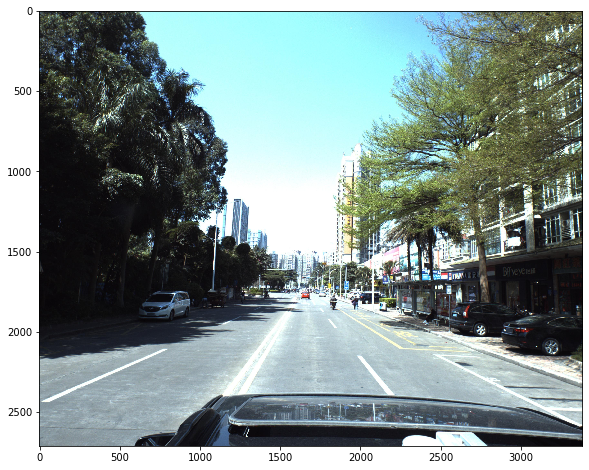

In [3]:
def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

img = imread(PATH + 'train_images/ID_8a6e65317' + '.jpg')
IMG_SHAPE = img.shape

plt.figure(figsize=(15,8))
plt.imshow(img);

In [4]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

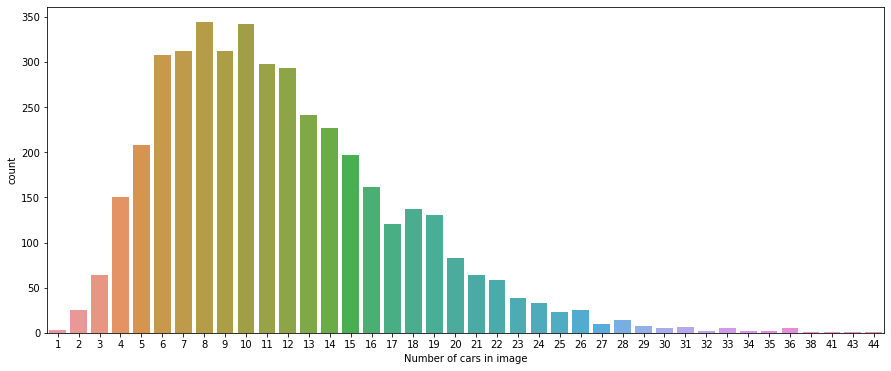

In [5]:
lens = [len(str2coords(s)) for s in train['PredictionString']]

plt.figure(figsize=(15,6))
sns.countplot(lens);
plt.xlabel('Number of cars in image');

In [6]:
points_df = pd.DataFrame()
for col in ['x', 'y', 'z', 'yaw', 'pitch', 'roll']:
    arr = []
    for ps in train['PredictionString']:
        coords = str2coords(ps)
        arr += [c[col] for c in coords]
    points_df[col] = arr

print('len(points_df)', len(points_df))
points_df.head()

len(points_df) 49684


,x,y,z,yaw,pitch,roll
0,7.96539,3.20066,11.0225,0.254839,-2.57534,-3.10256
1,9.60332,4.66632,19.3390,0.181647,-1.46947,-3.12159
2,10.39000,11.22190,59.7825,0.163072,-1.56865,-3.11754
3,-9.59236,5.13662,24.7337,0.141942,-3.13950,3.11969
4,9.83335,13.26890,72.9323,0.163068,-2.08578,-3.11754


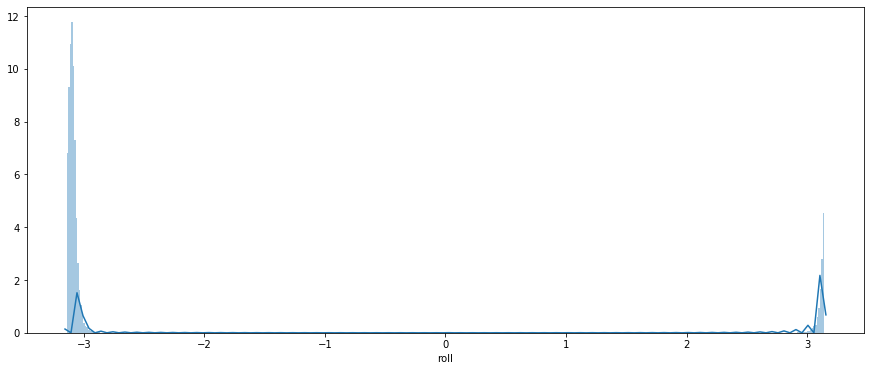

In [13]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['roll'], bins=500);
plt.xlabel('roll')
plt.show()

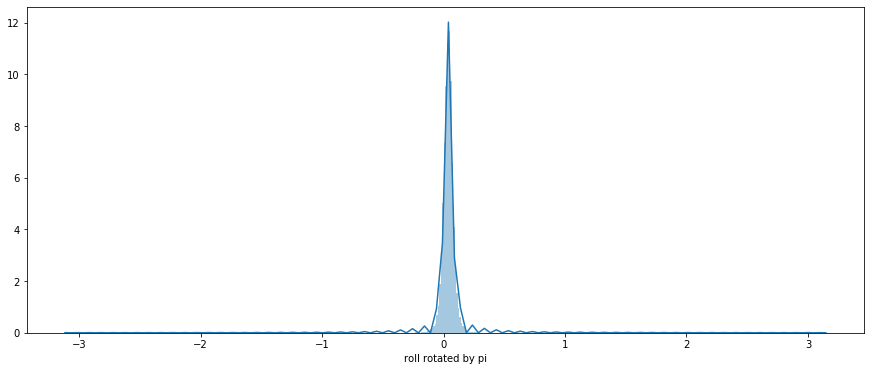

In [14]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

plt.figure(figsize=(15,6))
sns.distplot(points_df['roll'].map(lambda x: rotate(x, np.pi)), bins=500);
plt.xlabel('roll rotated by pi')
plt.show()

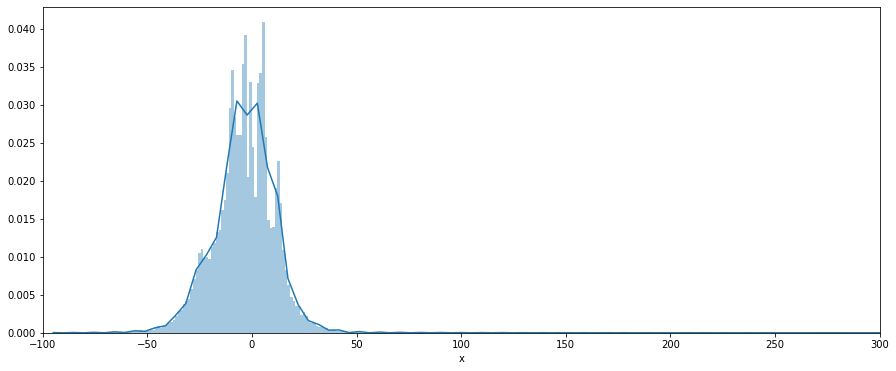

In [7]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['x'], bins=500);
plt.xlabel('x')
plt.xlim(-100, 300)
plt.show()

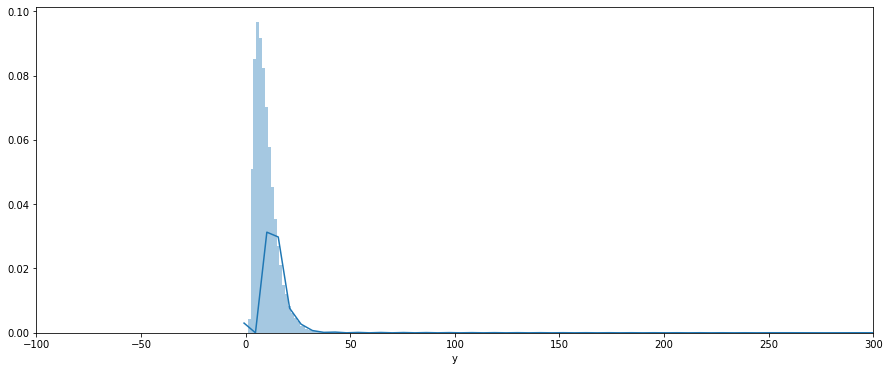

In [8]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['y'], bins=500);
plt.xlabel('y')
plt.xlim(-100, 300)
plt.show()

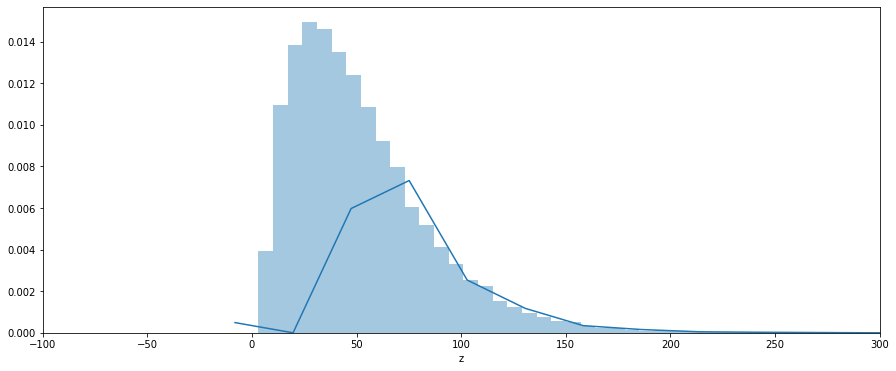

In [9]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['z'], bins=500);
plt.xlabel('z')
plt.xlim(-100, 300)
plt.show()

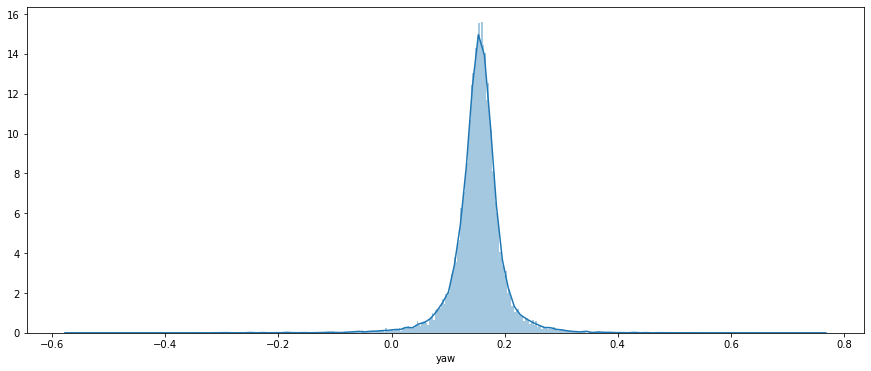

In [10]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['yaw'], bins=500);
plt.xlabel('yaw')
plt.show()

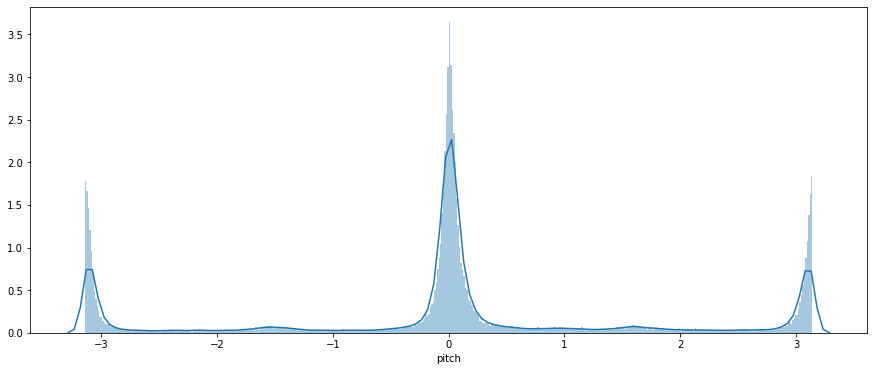

In [11]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['pitch'], bins=500);
plt.xlabel('pitch')
plt.show()

In [ ]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

plt.figure(figsize=(15,6))
sns.distplot(points_df['roll'].map(lambda x: rotate(x, np.pi)), bins=500);
plt.xlabel('roll rotated by pi')
plt.show()

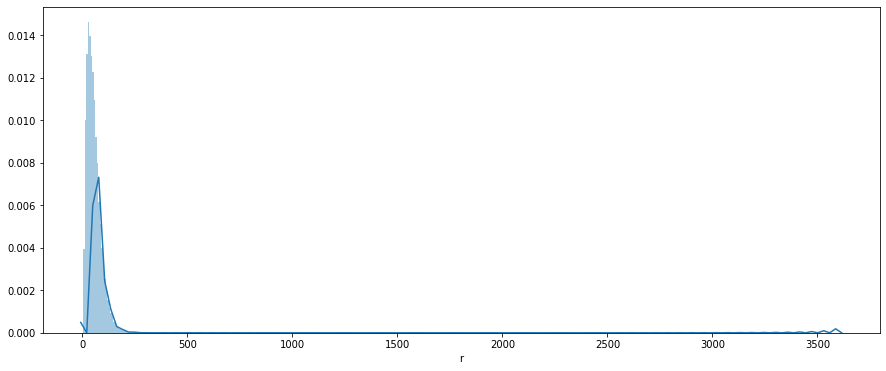

In [20]:
r = np.sqrt(points_df['x']**2 + points_df['y']**2 + points_df['z']**2)

plt.figure(figsize=(15,6))
sns.distplot(r , bins=500);
plt.xlabel('r')
plt.show()


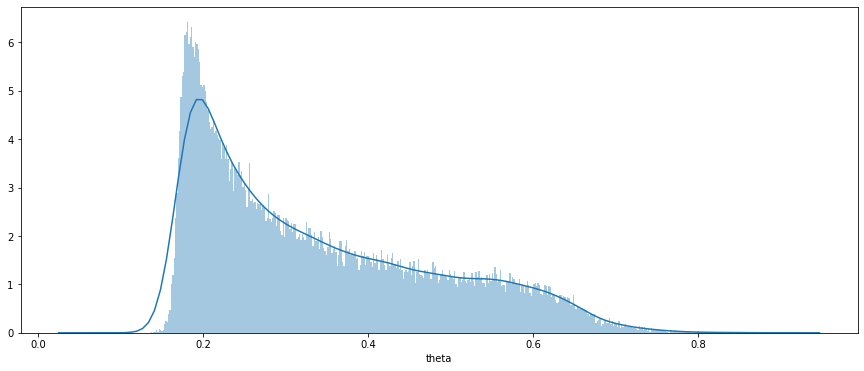

In [22]:
plt.figure(figsize=(15,6))
theta = np.arccos(points_df['z']/r)
sns.distplot(theta , bins=500);
plt.xlabel('theta')
plt.show()

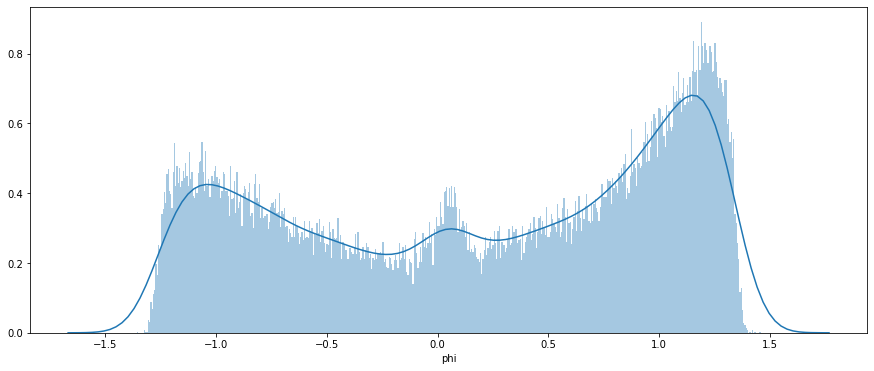

In [16]:
plt.figure(figsize=(15,6))
phi = np.arctan2(points_df['y'],points_df['x'])
sns.distplot(phi.map(lambda x: rotate(x, -np.pi/2)) , bins=500);
plt.xlabel('phi')
plt.show()

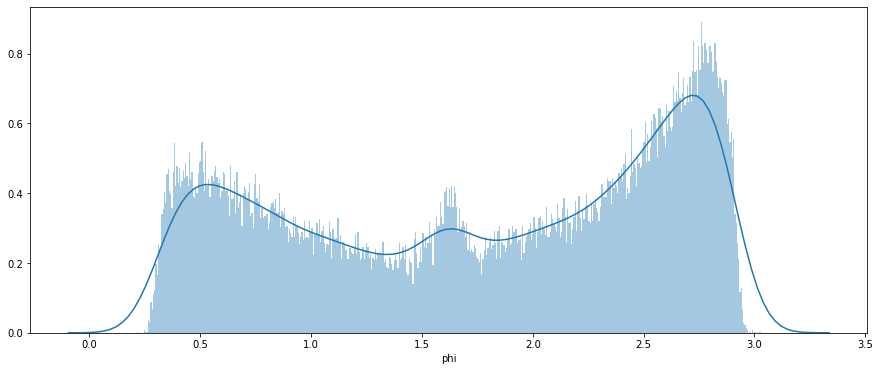

In [18]:
plt.figure(figsize=(15,6))
phi = np.arctan2(points_df['y'],points_df['x'])
sns.distplot(phi , bins=500);
plt.xlabel('phi')
plt.show()

In [55]:
x = r*np.sin(theta)*np.cos(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(theta)

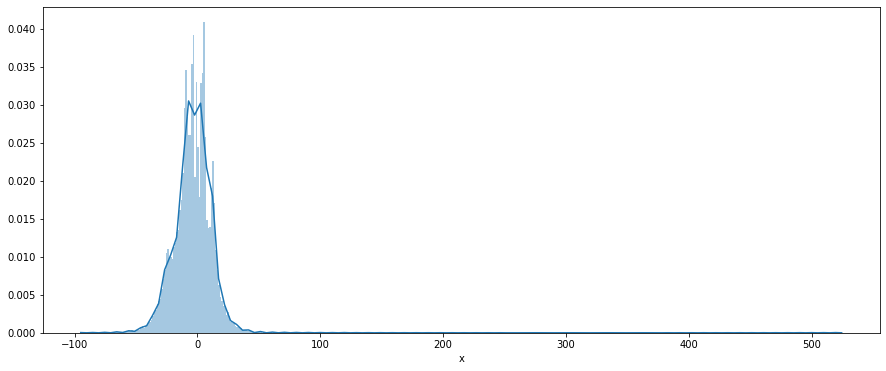

In [56]:
plt.figure(figsize=(15,6))
sns.distplot(x , bins=500);
plt.xlabel('x')
plt.show()

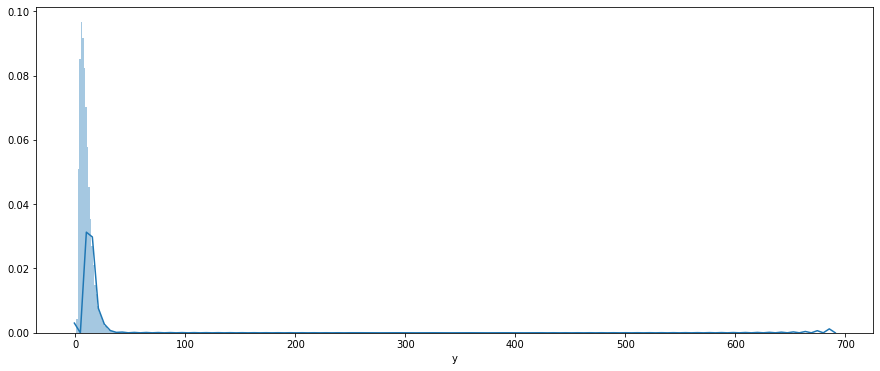

In [57]:
plt.figure(figsize=(15,6))
sns.distplot(y , bins=500);
plt.xlabel('y')
plt.show()

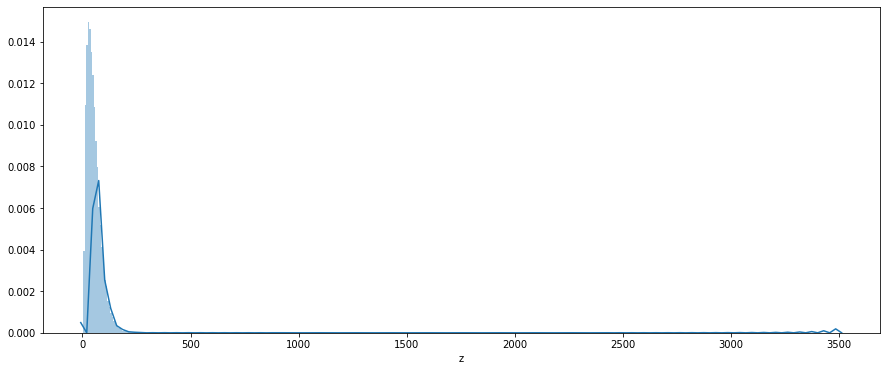

In [52]:
plt.figure(figsize=(15,6))
sns.distplot(z , bins=500);
plt.xlabel('z')
plt.show()